In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader,DirectoryLoader
from langchain_astradb import AstraDBVectorStore
from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel,Field
from langchain_core.output_parsers import StrOutputParser
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langgraph.graph import END, StateGraph, START
from langchain import hub
from langchain.schema import Document
from typing import List,Literal
from typing_extensions import TypedDict
from langchain.schema import Document
from pprint import pprint
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
load_dotenv()
gemini_embeddings = GoogleGenerativeAIEmbeddings(model = "models/embedding-001")
ASTRA_DB_API = os.getenv("ASTRA_API_KEY")
ASTRA_ENDPOINT = os.getenv("DB_ENDPOINT")

In [3]:
llm = ChatGoogleGenerativeAI(model = "gemini-1.5-pro",api_key = GOOGLE_API_KEY,temperature = 0.2)
print(llm.invoke("Who are you?").content)

I am a large language model, trained by Google. 

Here's what that means:

* **I am a computer program:** I don't have feelings, thoughts, or experiences like humans do.
* **I am trained on a massive amount of text data:** This allows me to communicate and generate human-like text in response to a wide range of prompts and questions. 
* **I am still under development:** I am constantly learning and improving my abilities.

How can I help you today? 



In [4]:
vector_store = AstraDBVectorStore(token = ASTRA_DB_API,
                                      api_endpoint = ASTRA_ENDPOINT,
                                      embedding = gemini_embeddings,
                                      namespace = "law",
                                      collection_name = "langgraph_RAG")

vector_store.similarity_search("Budget")

[Document(metadata={'source': 'data\\budget_speech (1).pdf', 'page': 2}, page_content='CONTENTS  \n \nPART – A \n Page No.  \nIntroduction 1 \nGlobal Context  1 \nInterim Budget  2 \nBudget Theme  2 \nBudget Priorities  2 \n(i) Productivity and resilience in Agriculture   \n(ii) Employment & Skilling  \n(iii) Inclusive Human Resource Development and Social Justice   \n(iv) Manufacturing & Services  \n(v) Urban Development   \n(vi) Energy Security  \n(vii) Infrastructure  \n(viii) Innovation, Research & Development  \n(ix) Next Generation Reforms  \nBudget Estimates 2024- 25 20 \n \n \nPART – B'),
 Document(metadata={'source': 'data\\budget_speech (1).pdf', 'page': 5}, page_content='pursuit of ‘ Viksit Bharat’. In line with the strategy set out in the interim \nbudget, this budget envisages sustained efforts on the following 9 priorities \nfor generating ample opportunities for all.   \n1) Productivity and resilience in Agriculture  \n2) Employment & Skilling  \n3) Inclusive Human Resou

In [5]:
retriever = vector_store.as_retriever()

In [6]:
class GraphState(TypedDict):
    question : str
    generation : str
    documents : List[str]
    route: str

In [33]:
def router(state: GraphState) -> str:
    question = state["question"]

    class RouteQuery(BaseModel):
        datasource: Literal["vectorstore", "wiki_search"] = Field(..., description="For a given user question decide whether to route it to vectorstore or wiki_search")

    llm_router = llm.with_structured_output(RouteQuery)

    system = """You are an expert at routing a user question to a vectorstore or wiki_search.
    The vectorstore contains documents related to Indian law and budget 2024.
    Use the vectorstore for questions on these topics. Otherwise, use wiki_search."""

    route_prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "{question}")])

    question_router = route_prompt | llm_router

    response = question_router.invoke({"question": question})
    return response.datasource

In [34]:
def retrieve(state: GraphState):
    question = state["question"]
    print(question)
    prompt = hub.pull("rlm/rag-prompt")
    rag_chain = prompt | llm | StrOutputParser()
    docs = retriever.get_relevant_documents(question)

    generation = rag_chain.invoke({"context": docs, "question": question})
    print(generation)
    state["generation"] = generation
    state["documents"] = docs

In [35]:
def wiki_search(state: GraphState):
    question = state["question"]
    arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
    arxiv = ArxivQueryRun(api_wrapper=arxiv_wrapper)
    print(question)
    api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=200)  
    wiki = WikipediaQueryRun(api_wrapper=api_wrapper)

    docs = wiki.invoke(question)
    print(docs)
    wiki_result = Document(page_content=docs)
    state["documents"] = [wiki_result]
    state["generation"] = "Wiki search completed"

In [37]:
workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve)
workflow.add_node("wiki_search", wiki_search)

workflow.add_conditional_edges(START, router, {
    "wiki_search": "wiki_search",
    "vectorstore": "retrieve",
})

workflow.add_edge("wiki_search", END)
workflow.add_edge("retrieve", END)

app = workflow.compile()

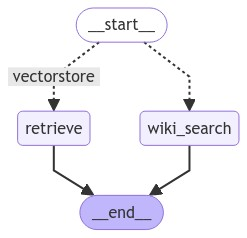

In [31]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [40]:
inputs = {"question": "What are some key points about Indian Budget 2024"}
for output in app.stream(inputs):
    for node_output in output:
        print(f"Node '{node_output['node']}':")
        for key, value in node_output['data'].items():
            pprint(f"  {key}: {value}")

What are some key points about Indian Budget 2024
The Indian Budget 2024, presented by Finance Minister Nirmala Sitharaman on July 23, 2024, focuses on nine key priorities for growth. These priorities include agriculture, employment and skilling, human resource development, manufacturing, urban development, energy security, infrastructure, innovation, and next-generation reforms. The budget aims to create opportunities for all citizens and contribute to India's development. 

